In [1]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Loading the dataset

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

# Step 2: Specify the path to your dataset in Google Drive
# Adjust the path below based on where your dataset is located in your Drive
image_path = '/content/drive/My Drive/dataset/men-women-dataset'

# Step 3: Function to walk through the directory and print the number of directories and images
def walk_through_dir(dir_path):
    """Walk through the specified directory and print the number of subdirectories and files."""
    print("dir path", dir_path)
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Step 4: Call the function to walk through the dataset directory and print details
walk_through_dir(image_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dir path /content/drive/My Drive/dataset/men-women-dataset
There are 2 directories and 0 images in '/content/drive/My Drive/dataset/men-women-dataset'.
There are 2 directories and 0 images in '/content/drive/My Drive/dataset/men-women-dataset/traindata'.
There are 0 directories and 750 images in '/content/drive/My Drive/dataset/men-women-dataset/traindata/men'.
There are 0 directories and 750 images in '/content/drive/My Drive/dataset/men-women-dataset/traindata/women'.
There are 2 directories and 0 images in '/content/drive/My Drive/dataset/men-women-dataset/testdata'.
There are 0 directories and 250 images in '/content/drive/My Drive/dataset/men-women-dataset/testdata/women'.
There are 0 directories and 250 images in '/content/drive/My Drive/dataset/men-women-dataset/testdata/men'.


In [4]:
# Define the training and test directories based on your Google Drive location
train_dir = image_path+ "/traindata"
test_dir = image_path+ "/testdata"

train_dir, test_dir  # Display the paths

('/content/drive/My Drive/dataset/men-women-dataset/traindata',
 '/content/drive/My Drive/dataset/men-women-dataset/testdata')

Understand the dataset

['/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000524.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000566.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000521.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000526.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000535.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000537.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000517.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000494.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000502.jpg', '/content/drive/My Drive/dataset/men-women-dataset/traindata/men/00000493.jpg']
Random image path: /content/drive/My Drive/dataset/men-women-dataset/traindata/women/00001135.jpg
Image class: women
Image height: 720
Image width: 1280


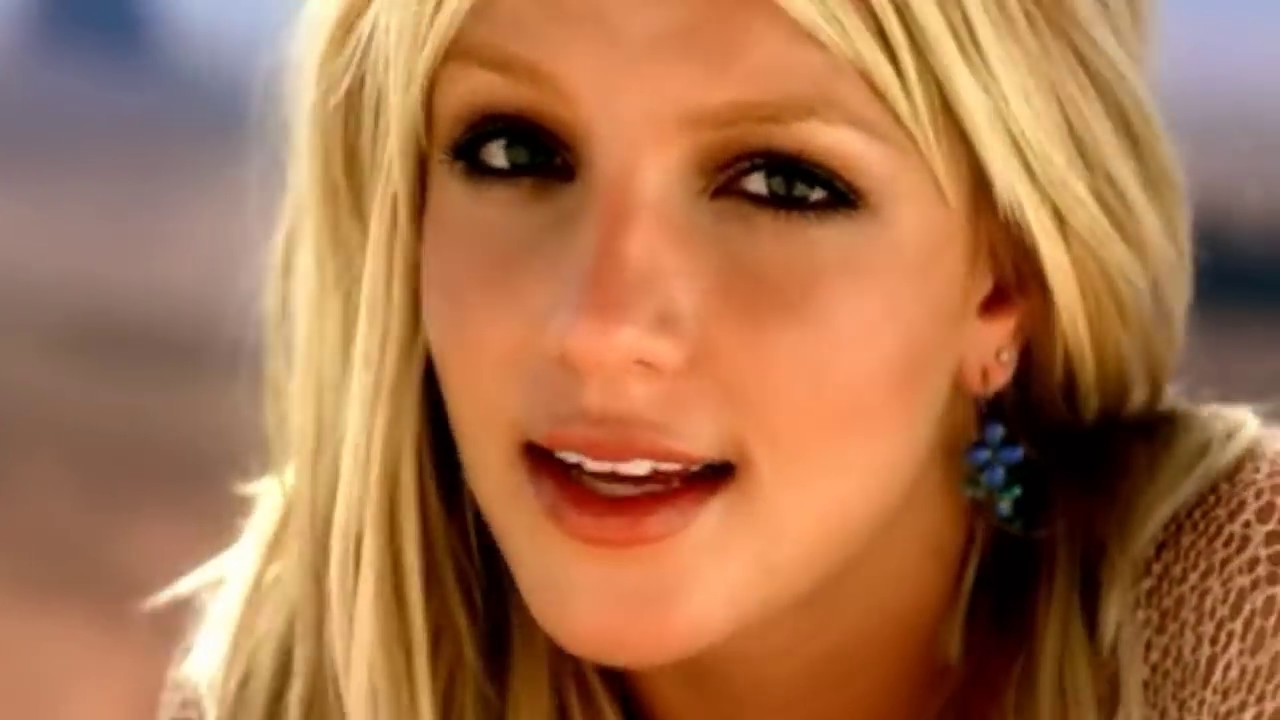

In [5]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
import glob

# Assuming image_path is defined to point to the root of your dataset
image_path = image_path  # Adjust this based on your structure

# Get all image paths with .jpg extension
image_path_list = glob.glob(f"{image_path}/*/*/*.jpg")

# Display the first few image paths to verify
print(image_path_list[:10])  # Show the first 10 image paths


# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Use matplotlib to visualize the image

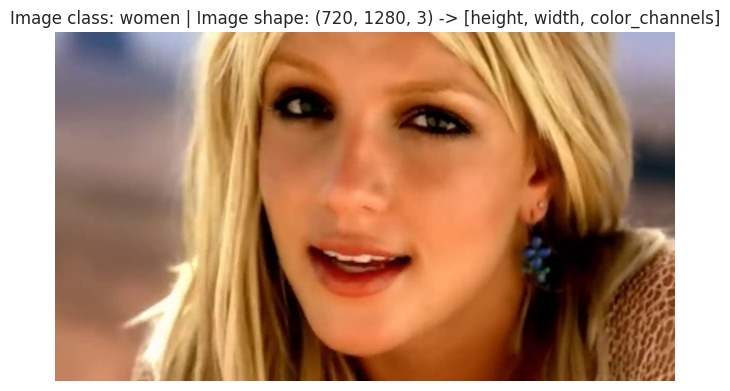

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

Transforming data or pre processing it and bringing it to same pixels

In [36]:
import torch
from torch.utils.data import DataLoader #converting to pyton iterables
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

#transform the image
data_transform = transforms.Compose([
    #resize the image
    transforms.Resize(size=IMAGE_SIZE),
    #flig the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), #p is probability with 50% chance
    transforms.ToTensor() #convert pixel of 0-255 into 0.0 to 1.0
])


function plot transformed image to visualize the changes

In [37]:
def plot_transformed_images(image_paths, transform, n=4, seed=42):
    random.seed(seed)
    random_image_paths=random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original size: {f.size}")
            ax[0].axis("off")

            #transform the plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

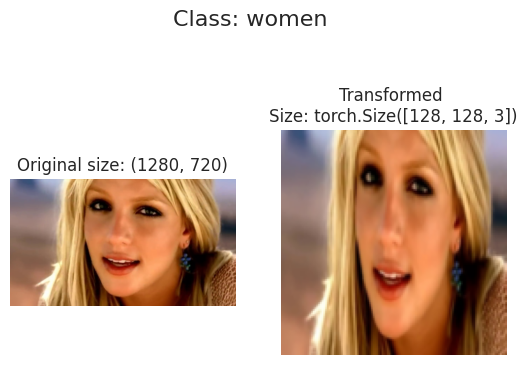

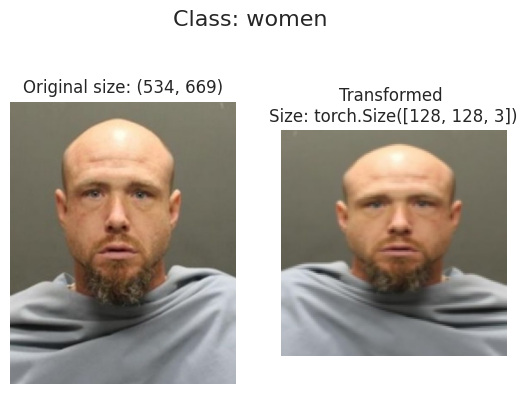

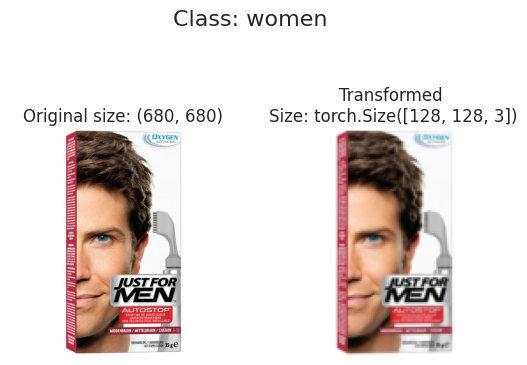

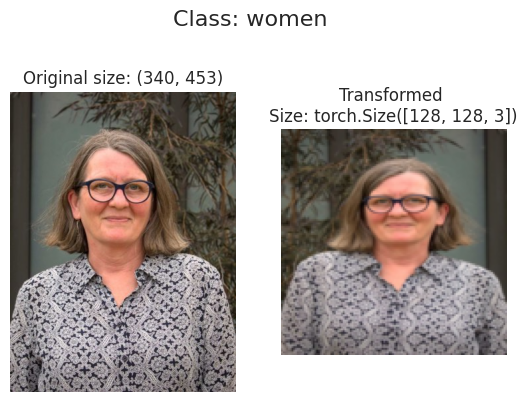

In [38]:
plot_transformed_images(image_path_list, transform=data_transform, n=4)

We have created data transformation func, we now load our dataset using this func. easiest way to load data is ImageFolder func in PyTorch

In [39]:
import os

# Check if the paths exist and list the contents
print("Train directory contents:", os.listdir(train_dir))
print("Test directory contents:", os.listdir(test_dir))


Train directory contents: ['men', 'women']
Test directory contents: ['women', 'men']


In [40]:
from torchvision import datasets

# Creating the training set
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

# Creating the test set
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)


print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1493
    Root location: /content/drive/My Drive/dataset/men-women-dataset/traindata
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 499
    Root location: /content/drive/My Drive/dataset/men-women-dataset/testdata
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [41]:
# Print basic dataset info
print(f"Train data length: {len(train_data)}\nTest data length: {len(test_data)}")

# Access the first image and label from the training set to print shape
train_image, train_label = train_data[0]  # Get first image and label from the training set
test_image, test_label = test_data[0]     # Get first image and label from the test set

# Print shapes of the first image in both train and test sets
print(f"Train image shape: {train_image.shape} | Label: {train_label}")
print(f"Test image shape: {test_image.shape} | Label: {test_label}")


Train data length: 1493
Test data length: 499
Train image shape: torch.Size([3, 128, 128]) | Label: 0
Test image shape: torch.Size([3, 128, 128]) | Label: 0


In [42]:
#get class names as a list
class_names = train_data.classes
print("Class names: ", class_names)

#can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ", class_dict)

Class names:  ['men', 'women']
Class names as a dict:  {'men': 0, 'women': 1}


In [43]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Image Name: {class_names[label]}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.8980, 0.8863, 0.8902,  ..., 0.7804, 0.7725, 0.7647],
         [0.8980, 0.8863, 0.8902,  ..., 0.7804, 0.7725, 0.7647],
         [0.9020, 0.8902, 0.8941,  ..., 0.7804, 0.7765, 0.7686],
         ...,
         [0.1608, 0.1569, 0.1451,  ..., 0.1451, 0.1451, 0.1373],
         [0.1490, 0.1373, 0.1373,  ..., 0.1490, 0.1412, 0.1333],
         [0.1333, 0.1255, 0.1333,  ..., 0.1529, 0.1412, 0.1333]],

        [[0.8549, 0.8431, 0.8471,  ..., 0.7647, 0.7529, 0.7451],
         [0.8549, 0.8431, 0.8471,  ..., 0.7608, 0.7529, 0.7451],
         [0.8588, 0.8471, 0.8471,  ..., 0.7608, 0.7608, 0.7490],
         ...,
         [0.0980, 0.0902, 0.0784,  ..., 0.0902, 0.0941, 0.0941],
         [0.0863, 0.0706, 0.0706,  ..., 0.0941, 0.0902, 0.0941],
         [0.0745, 0.0667, 0.0745,  ..., 0.0941, 0.0941, 0.0902]],

        [[0.8471, 0.8353, 0.8392,  ..., 0.7294, 0.7255, 0.7294],
         [0.8471, 0.8353, 0.8392,  ..., 0.7333, 0.7255, 0.7294],
         [0.8510, 0.8392, 0.8431,  ..., 0.73

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


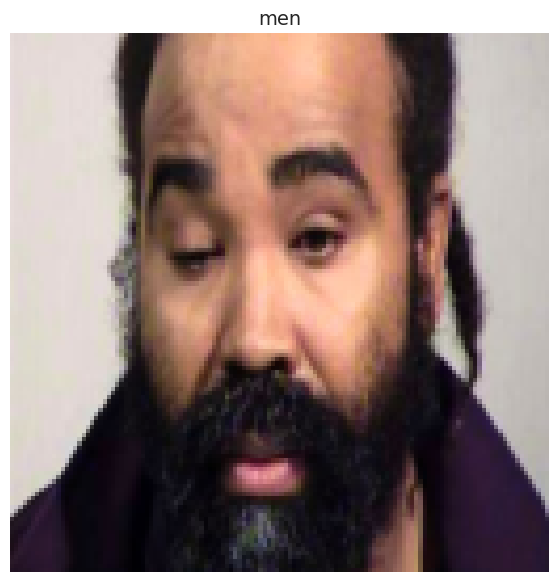

In [44]:
# visualize with matplot lib
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Turn data into dataloaders

In [45]:
os.cpu_count()

2

In [46]:
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              num_workers=NUM_WORKERS,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             num_workers=NUM_WORKERS,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b105c29f2e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b105c29ce80>)

In [47]:
#get the batch image and cheeck the shape
img, label = next(iter(train_dataloader))

# Note that batch size will now be 128.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


Creating CNN classifier

In [50]:
# Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),  # Added stride
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Stride matches kernel size
        )

        # Second convolutional layer
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # Added stride
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Stride matches kernel size
        )

        # Third convolutional layer
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # Added stride
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Stride matches kernel size
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the feature maps into a 1D vector
            nn.Linear(in_features=64 * 16 * 16, out_features=2)  # Fully connected layer for classification
        )


    # Forward pass through the network
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)  # Pass through the first conv layer
        x = self.conv_layer_2(x)  # Pass through the second conv layer
        x = self.conv_layer_3(x)  # Pass through the third conv layer
        x = self.classifier(x)    # Pass through the fully connected layer (classifier)
        return x

# Instantiate the model
model = ImageClassifier().to(device)


Try forward pass on single image

In [51]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[ 0.0060, -0.0377]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5109, 0.4891]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


understand the model

In [52]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
# do a test pass through of an example input size
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─ReLU: 2-2                         [1, 64, 128, 128]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 128, 128]         128
│    └─MaxPool2d: 2-4                    [1, 64, 64, 64]           --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 64, 64, 64]           36,928
│    └─ReLU: 2-6                         [1, 64, 64, 64]           --
│    └─BatchNorm2d: 2-7                  [1, 64, 64, 64]           128
│    └─MaxPool2d: 2-8                    [1, 64, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           36,928
│ 

Function for train step and test step

In [53]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Function to combine train and test step

In [54]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [58]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 22.5532 | train_acc: 0.5574 | test_loss: 5.6023 | test_acc: 0.5334
Epoch: 2 | train_loss: 3.6481 | train_acc: 0.5407 | test_loss: 2.1412 | test_acc: 0.5339
Epoch: 3 | train_loss: 2.0839 | train_acc: 0.5543 | test_loss: 0.7958 | test_acc: 0.5434
Epoch: 4 | train_loss: 1.3769 | train_acc: 0.5677 | test_loss: 2.9484 | test_acc: 0.5499
Epoch: 5 | train_loss: 1.0566 | train_acc: 0.5700 | test_loss: 0.7994 | test_acc: 0.5610
Epoch: 6 | train_loss: 0.9733 | train_acc: 0.5686 | test_loss: 0.9030 | test_acc: 0.4976
Epoch: 7 | train_loss: 0.7665 | train_acc: 0.5786 | test_loss: 0.6463 | test_acc: 0.6194
Epoch: 8 | train_loss: 1.0574 | train_acc: 0.5580 | test_loss: 0.7778 | test_acc: 0.5778
Epoch: 9 | train_loss: 0.8302 | train_acc: 0.5960 | test_loss: 1.0554 | test_acc: 0.5364
Epoch: 10 | train_loss: 0.8347 | train_acc: 0.5940 | test_loss: 0.8701 | test_acc: 0.5879
Epoch: 11 | train_loss: 0.8621 | train_acc: 0.5889 | test_loss: 0.6780 | test_acc: 0.6143
Epoch: 12 | train_

In [59]:
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

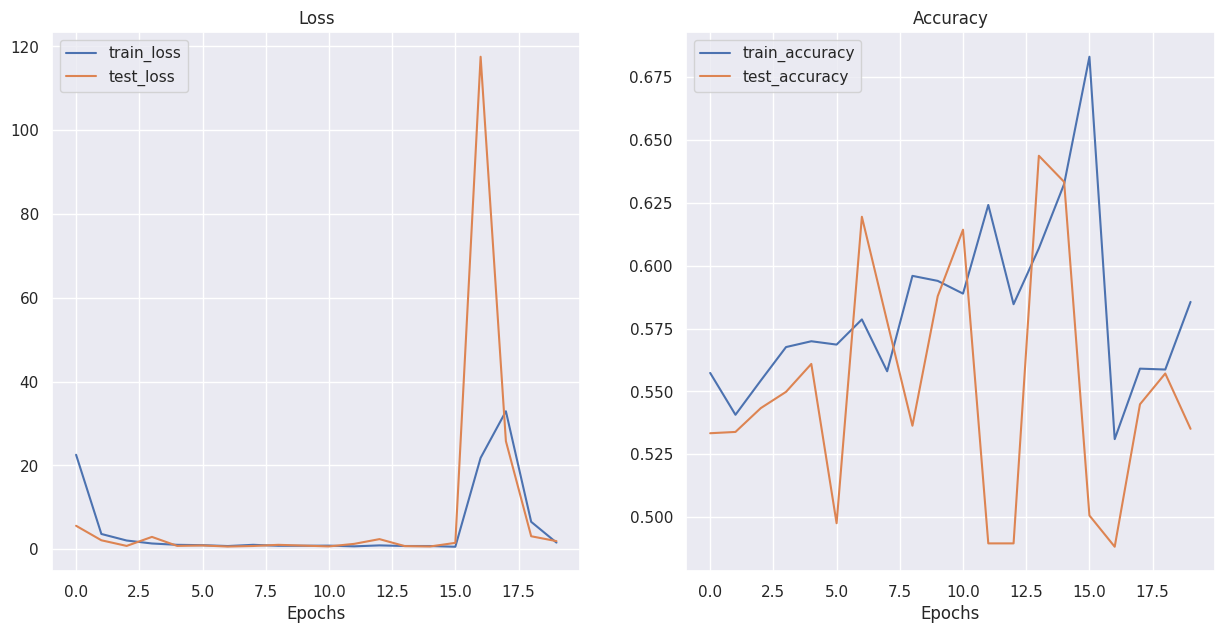

In [60]:
plot_loss_curves(model_results)

Make prediction to see how our model works

In [62]:
# Choose a image.
custom_image_path = image_path+ "/testdata/women/00001324.jpg"

import torchvision
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.2431, 0.2431, 0.2431,  ..., 0.2980, 0.2980, 0.2980],
         [0.2431, 0.2431, 0.2431,  ..., 0.2980, 0.2980, 0.2980],
         [0.2431, 0.2431, 0.2431,  ..., 0.2941, 0.2941, 0.2941],
         ...,
         [0.5765, 0.5490, 0.5373,  ..., 0.5804, 0.5922, 0.6039],
         [0.5490, 0.5529, 0.5529,  ..., 0.5765, 0.5961, 0.6157],
         [0.5490, 0.5529, 0.5529,  ..., 0.5765, 0.5961, 0.6157]],

        [[0.1961, 0.1961, 0.1961,  ..., 0.3412, 0.3412, 0.3412],
         [0.1961, 0.1961, 0.1961,  ..., 0.3412, 0.3412, 0.3412],
         [0.1961, 0.1961, 0.1961,  ..., 0.3373, 0.3373, 0.3373],
         ...,
         [0.3686, 0.3412, 0.3294,  ..., 0.3373, 0.3490, 0.3608],
         [0.3412, 0.3451, 0.3451,  ..., 0.3333, 0.3529, 0.3725],
         [0.3412, 0.3451, 0.3451,  ..., 0.3333, 0.3529, 0.3725]],

        [[0.2353, 0.2353, 0.2353,  ..., 0.4118, 0.4118, 0.4118],
         [0.2353, 0.2353, 0.2353,  ..., 0.4118, 0.4118, 0.4118],
         [0.2353, 0.2353, 0.2353,  ..

In [63]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 650, 500])
New shape: torch.Size([3, 128, 128])


In [64]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    custom_image_pred

Custom image transformed shape: torch.Size([3, 128, 128])
Unsqueezed custom image shape: torch.Size([1, 3, 128, 128])


In [65]:
# Let's convert them from logits -> prediction probabilities -> prediction labels
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-2.6451,  2.6339]], device='cuda:0')
Prediction probabilities: tensor([[0.0051, 0.9949]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


In [66]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'women'

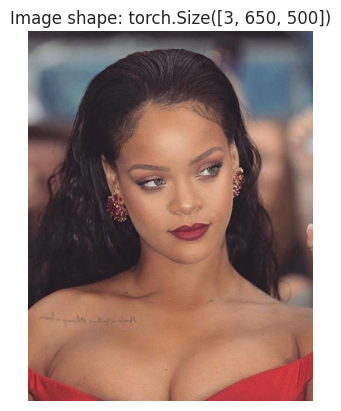

In [67]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);